In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# ----------------------
# Define a VAE
# ----------------------
class VAE(nn.Module):
    def __init__(self, latent_dim=16):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 400),
            nn.ELU(),
            nn.Linear(400, 400),
            nn.ELU(),
            nn.Linear(400, 2*latent_dim) # outputs mean and logvar
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ELU(),
            nn.Linear(400, 400),
            nn.ELU(),
            nn.Linear(400, 28*28),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.latent_dim], h[:, self.latent_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

def vae_loss(recon, x, mu, logvar):
    # BCE = nn.functional.binary_cross_entropy(recon, x, reduction='sum')
    MSE = nn.functional.mse_loss(recon, x, reduction='sum')
    logvar_clamped = torch.clamp(logvar, min=-3, max=5)  # Clamp logvar to avoid extreme values
    KLD = -0.5 * torch.sum(1 + logvar_clamped - mu.pow(2) - logvar_clamped.exp())
    # return BCE + KLD
    return MSE + KLD

# ----------------------
# Train or load a pretrained VAE
# ----------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='./mnist_data', train=True, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

latent_dim = 12
vae = VAE(latent_dim=latent_dim).to(device)
opt_vae = torch.optim.Adam(vae.parameters(), lr=5e-3)

# Train the VAE (for demonstration, just a few epochs; in practice, train longer)
epochs = 10  # You might want to increase this for better results
for epoch in range(epochs):
    vae.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        opt_vae.zero_grad()
        recon, mu, logvar = vae(x)
        loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        opt_vae.step()
        total_loss += loss.item()
    print(f"VAE Epoch {epoch+1}, Loss: {total_loss/len(train_loader.dataset)}")

In [13]:
# ----------------------
# Define Flow Model
# ----------------------
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64, auton: bool = False):
        super().__init__()
        self.auton = auton
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim)
        )

    def forward(self, t: torch.Tensor, x_t: torch.Tensor) -> torch.Tensor:
        if self.auton:
            t = torch.zeros_like(t) # Autonomous system
        return self.net(torch.cat((t, x_t), dim=-1))

    def step(self, x_t: torch.Tensor, t_start: torch.Tensor, t_end: torch.Tensor) -> torch.Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        mid_t = t_start + (t_end - t_start) / 2
        mid_x = x_t + self(t=t_start, x_t=x_t) * (t_end - t_start) / 2
        return x_t + (t_end - t_start) * self(t=mid_t, x_t=mid_x)

# ----------------------
# Flow matching on the latent space
# ----------------------
flow = Flow(dim=latent_dim, h=512, auton=False).to(device)
optimizer = torch.optim.AdamW(flow.parameters(), lr=5e-3, betas=(0.9, 0.999))
loss_fn = nn.MSELoss()

num_iterations = 2000
dataset_size = len(train_dataset)
batch_size = 256
num_batches_per_epoch = dataset_size // batch_size
num_epochs = num_iterations // num_batches_per_epoch

pbar = tqdm(total=num_iterations, desc="Training Flow in Latent Space")
flow.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)
        with torch.no_grad():
            # mu, logvar = vae.encode(images)
            # z_1 = vae.reparameterize(mu, logvar)
            z_1, _ = vae.encode(images)
        
        # Sample z_0 from Gaussian
        z_0 = torch.randn_like(z_1)

        with torch.no_grad():
            x0_expanded = z_0.unsqueeze(1)  # [B,1,D]
            x1_expanded = z_1.unsqueeze(0)  # [1,B,D]
            diff = x0_expanded - x1_expanded
            cost_matrix = torch.sum(diff**2, dim=2).cpu().numpy()

        row_idx, col_idx = linear_sum_assignment(cost_matrix)
        z_1_matched = z_1[col_idx]

        t = torch.rand(len(z_1_matched), 1).to(device)
        z_t = (1 - t) * z_0 + t * z_1_matched
        dz_t = z_1_matched - z_0

        optimizer.zero_grad()
        out = flow(t=t, x_t=z_t)
        loss = loss_fn(out, dz_t)
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'loss': loss.item()})
        pbar.update(1)
pbar.close()

Training Flow in Latent Space:  94%|█████████▍| 1880/2000 [02:22<00:09, 13.22it/s, loss=0.38] 


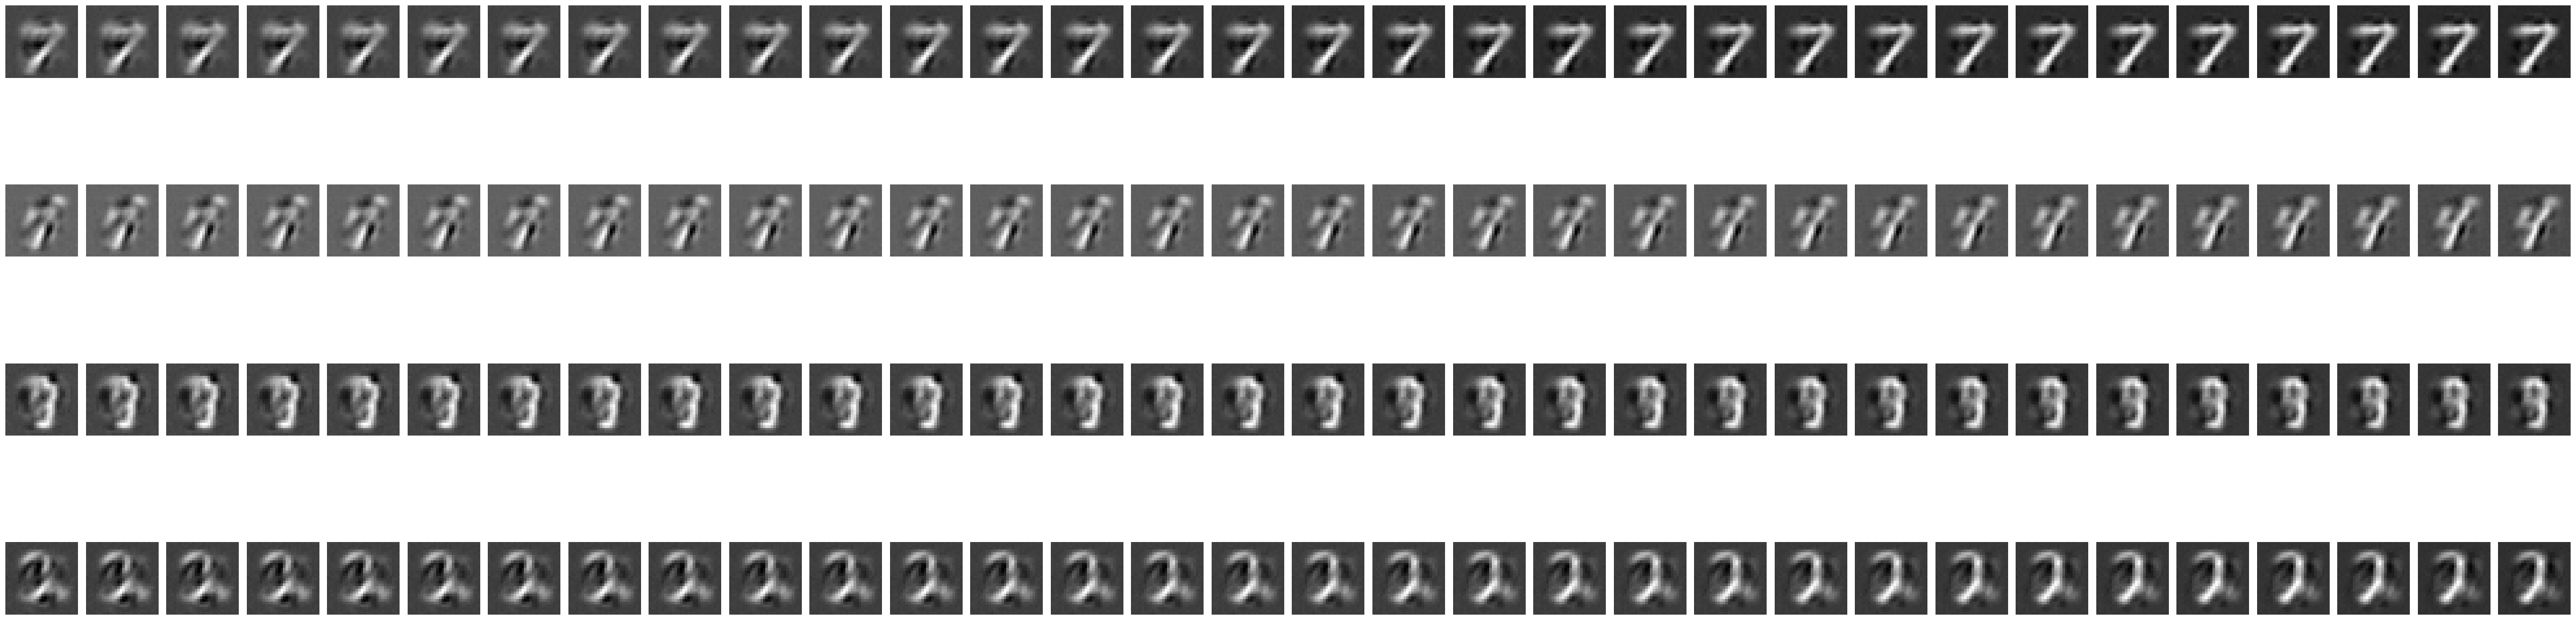

In [29]:
flow.eval()
n_steps = 32
n_trajs = 4
z = torch.randn(n_trajs, latent_dim).to(device)
time_steps = torch.linspace(0, 1.0, n_steps + 1).to(device)

flows = []
for i in range(n_steps):
    z = flow.step(x_t=z, t_start=time_steps[i], t_end=time_steps[i + 1])
    with torch.no_grad():
        decoded = vae.decode(z).cpu()
        decoded = 0.5*decoded + 0.5
    flows.append(decoded)
flows = torch.stack(flows, dim=1).cpu().detach()

# Plot
fig, axs = plt.subplots(n_trajs, n_steps, figsize=(n_steps*1.5, 15))
for traj in range(n_trajs):
    for i in range(n_steps):
        axs[traj, i].imshow(flows[traj, i, 0].numpy(), cmap='gray')
        axs[traj, i].axis('off')
plt.tight_layout()
plt.show()
plt.close()
